# 3.4 XGBoost

Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import plotly.express as px

import random
np.random.seed(123)
random.seed(123)

# machine learning packages
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from tempfile import mkdtemp
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer,accuracy_score,recall_score,precision_score,f1_score, roc_auc_score


# Filter warnings
import warnings
warnings.filterwarnings('ignore')

# Print all columns of a datafame
pd.set_option('display.max_columns', None)

# Table of Contents
* [Introduction](#introduction)
* [Data Loading](#data-loading)
* [Baseline Model](#baseline-model)
* [Model Optimization](#model-optimization)
    * [Hyperparameter Tuning](#hyperparameter-tuning)
    * [5-folds Cross Validation with Grid Search](#gridsearchcv)
* [Top Features](#top-features)

---

## Introduction <a id="introduction"></a>

**Streamlining Renewable Energy Site Selection with ML:
Predict the Suitability of Solar Energy Resources**

The goal of this project is to apply machine learning techniques to classify whether solar is suitable as the primary energy source for a location.

This can help energy decision makers and energy companies to simplify the complex site selection process, thereby accelerating the transition to clean and sustainable energy sources, ultimately contributing to the fight against climate change and energy crisis. 

This notebook will perform XGBoost Classifier on the renewable power plants data with geospatial data. We will also perform model optimization by tuning the hyperparameters to find the best model with the highest recall and accuracy score.

---

## Data Loading <a id="data-loading"></a>

In [2]:
df = pd.read_csv("./data/capstone_data_cleaned_for_model.csv")

df_shape = df.shape
cat_cols = len(df.select_dtypes('object').columns)
num_cols = len(df.select_dtypes('number').columns)

print(f'Rows: {df_shape[0]}')
print(f'Columns: {df_shape[1]}\n')

print(f'Total duplicate rows: {df.duplicated().sum()}')
print(f'Percentage duplicate rows: {df.duplicated().mean()}% \n')

print(f'Total null values: {df.isna().sum().sum()}')
print(f'Percentage null vales: {df.isna().mean().sum()}% \n')

df.info()

print("\n")

print(f'Number of categorical columns: {cat_cols}')
print(f'Number of numerical columns: {num_cols}')

Rows: 7784
Columns: 6

Total duplicate rows: 0
Percentage duplicate rows: 0.0% 

Total null values: 0
Percentage null vales: 0.0% 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7784 entries, 0 to 7783
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Longitude       7784 non-null   float64
 1   WindSpeed       7784 non-null   float64
 2   SolarRadiation  7784 non-null   float64
 3   Elevation       7784 non-null   float64
 4   Slope           7784 non-null   float64
 5   isSolar         7784 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 365.0 KB


Number of categorical columns: 0
Number of numerical columns: 6


---

## Baseline Model <a id="baseline-model"></a>

Set up the model

In [3]:
X = df.drop(columns=['isSolar'])
y = df['isSolar']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)

print(f'Shape of test set: {X_test.shape}')
print(f'Shape of train set: {X_train.shape}')

Shape of test set: (1557, 5)
Shape of train set: (6227, 5)


In [5]:
# Instantiate the model
base_XGB = XGBClassifier(random_state=1)

# Fit the model
base_XGB.fit(X_train, y_train)

# Scoring the model
base_XGB.score(X_train, y_train)
base_XGB.score(X_test, y_test)

print(f'Baseline XGB Train result: {base_XGB.score(X_train, y_train):.4f} accuracy.')
print(f'Baseline XGB Test result: {base_XGB.score(X_test, y_test):.4f} accuracy.')

Baseline XGB Train result: 0.9608 accuracy.
Baseline XGB Test result: 0.8426 accuracy.


We can see that the baseline model of random forest has a comparable accuracy compared to the baseline Random Forest model. However, it shows significant overfitting.

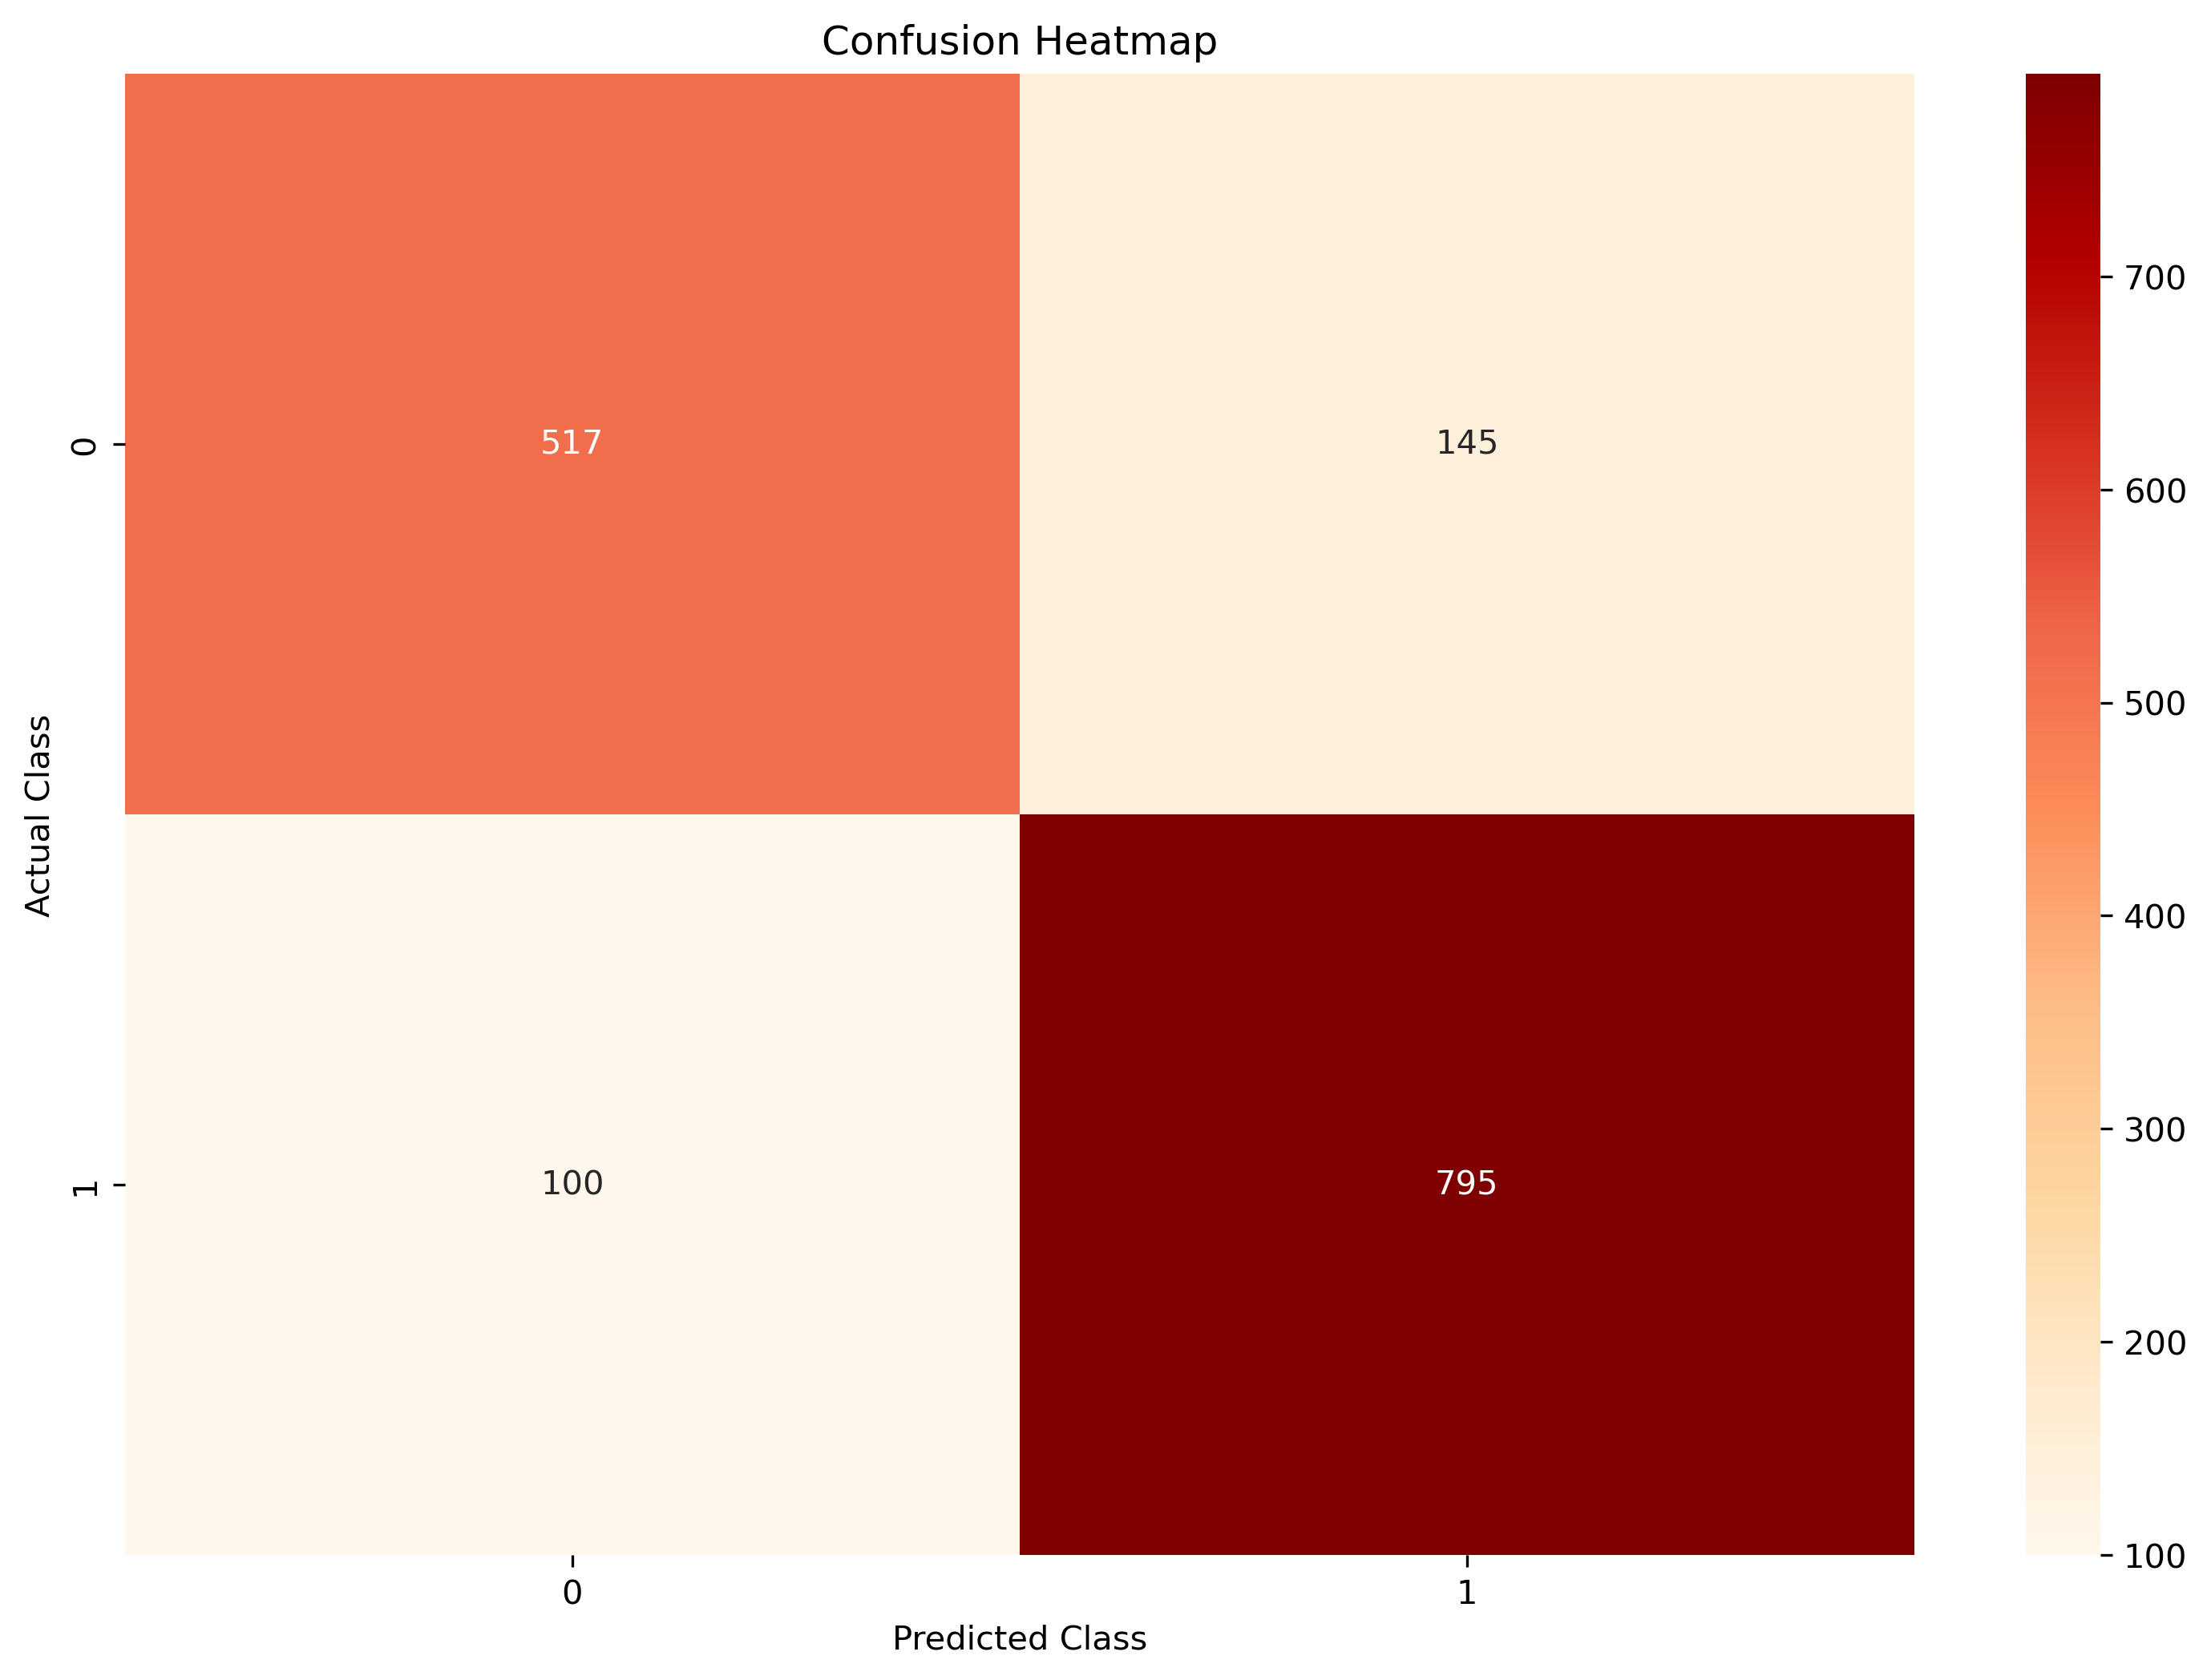

              precision    recall  f1-score   support

           0       0.84      0.78      0.81       662
           1       0.85      0.89      0.87       895

    accuracy                           0.84      1557
   macro avg       0.84      0.83      0.84      1557
weighted avg       0.84      0.84      0.84      1557



In [6]:
# Make classifications based on the test features, and assign the classifications to a variable
y_pred = base_XGB.predict(X_test)

predictions = y_test.unique()
predictions.sort()

# Build the confusion matrix as a dataframe
confusion_df = pd.DataFrame(confusion_matrix(y_test, y_pred))
confusion_df.index = [i for i in predictions]
confusion_df.columns = [i for i in predictions]

# Heatmap of the above
plt.figure(figsize=(12, 8), dpi=300)
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='OrRd') # Passing in fmt='d' prevents the counts from being displayed in scientific notation
plt.title('Confusion Heatmap')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

print(classification_report(y_test, y_pred))

In [7]:
# Model Evaluation metrics 
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))
print('ROC AUC Score : ' + str(roc_auc_score(y_test,y_pred)))

Accuracy Score : 0.8426461143224149
Precision Score : 0.8457446808510638
Recall Score : 0.888268156424581
F1 Score : 0.8664850136239782
ROC AUC Score : 0.834617461898091


In [8]:
# Create the score df
scores_df = {
    "ModelName": [],
    "Test Accuracy": [],
    "Test Precision": [],
    "Test Recall": [],
    "Test F1": [],
    "Test ROC AUC": []
}

def appendScores (model_name, y_test, y_pred):
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred)
    roc_auc = roc_auc_score(y_test,y_pred)

    scores_df["ModelName"].append(model_name)
    scores_df["Test Accuracy"].append(accuracy)
    scores_df["Test Precision"].append(precision)
    scores_df["Test Recall"].append(recall)
    scores_df["Test F1"].append(f1)
    scores_df["Test ROC AUC"].append(roc_auc)

    return pd.DataFrame(scores_df)

In [9]:
# Append the scores of the baseline logistic regression model to the dataframe
appendScores("Baseline_XGB", y_test, y_pred)

,ModelName,Test Accuracy,Test Precision,Test Recall,Test F1,Test ROC AUC
0,Baseline_XGB,0.842646,0.845745,0.888268,0.866485,0.834617


---

## Model Optimization <a id="model-optimization"></a>

### Hyperparameter Tuning <a id="hyperparameter-tuning"></a>

In [10]:
# Split the data into remainder and test sets
X_rem, X_test, y_rem, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# Print info on how the data has been split
print(f'The remainder set has {len(X_rem)} data points.')
print(f'The test set has {len(X_test)} data points.')

# Split the remainder set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_rem, y_rem, test_size=0.2, random_state=1, stratify=y_rem)

# Print info on how the data has been split
print(f'The train set has {len(X_train)} data points.')
print(f'The validation set has {len(X_val)} data points.')

The remainder set has 6227 data points.
The test set has 1557 data points.
The train set has 4981 data points.
The validation set has 1246 data points.


In [11]:
depths = list(range(1, 11, 1))
train_accuracies = []
validation_accuracies = []

for depth in depths:
    print(f'Fitting model: {depth}', end='\r')
    
    # Instantiate the model
    XGB_model = XGBClassifier(max_depth=depth, random_state=1)

    # Fit the model to the train set
    XGB_model.fit(X_train, y_train)
    
    # Append scores
    train_accuracies.append(XGB_model.score(X_train, y_train))
    validation_accuracies.append(XGB_model.score(X_val, y_val))

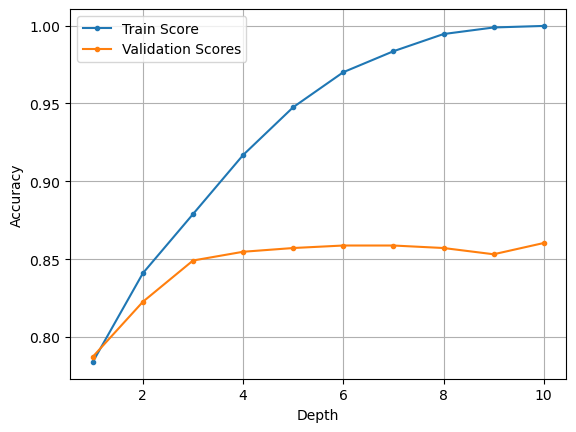

In [12]:
plt.figure()
plt.plot(depths, train_accuracies,label="Train Score",marker='.')
plt.plot(depths, validation_accuracies,label="Validation Scores",marker='.')
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()

As depth increases, the model overfits to the training set, due to the fact that the increasing number of decision boundaries makes the model separates more and more data points. At depth of 10, the model is able to separate all data points, reaching a train score of 100%.

The key is find a depth where the validation score is maximized while the train score is not too far away from it. Looking at the plot, I would say depth of 3 is the optimal depth, even though depth of 10 has the highest validation score.

In [13]:
best_depth = depths[np.argmax(validation_accuracies)]
print(f'The depth with the highest validation accuracy is: {best_depth}')

The depth with the highest validation accuracy is: 10


In [14]:
# Instantiate the model
XGB_3 = XGBClassifier(max_depth=3,random_state=1)

# Fit the model
XGB_3.fit(X_train, y_train)

# Scoring the model
XGB_3.score(X_train, y_train)
XGB_3.score(X_test, y_test)

print(f'XGB with a depth of 3 achieved a Train result: {XGB_3.score(X_train, y_train):.4f} accuracy.')
print(f'XGB with a depth of 3 achieved a Test result: {XGB_3.score(X_test, y_test):.4f} accuracy.')

XGB with a depth of 3 achieved a Train result: 0.8789 accuracy.
XGB with a depth of 3 achieved a Test result: 0.8259 accuracy.


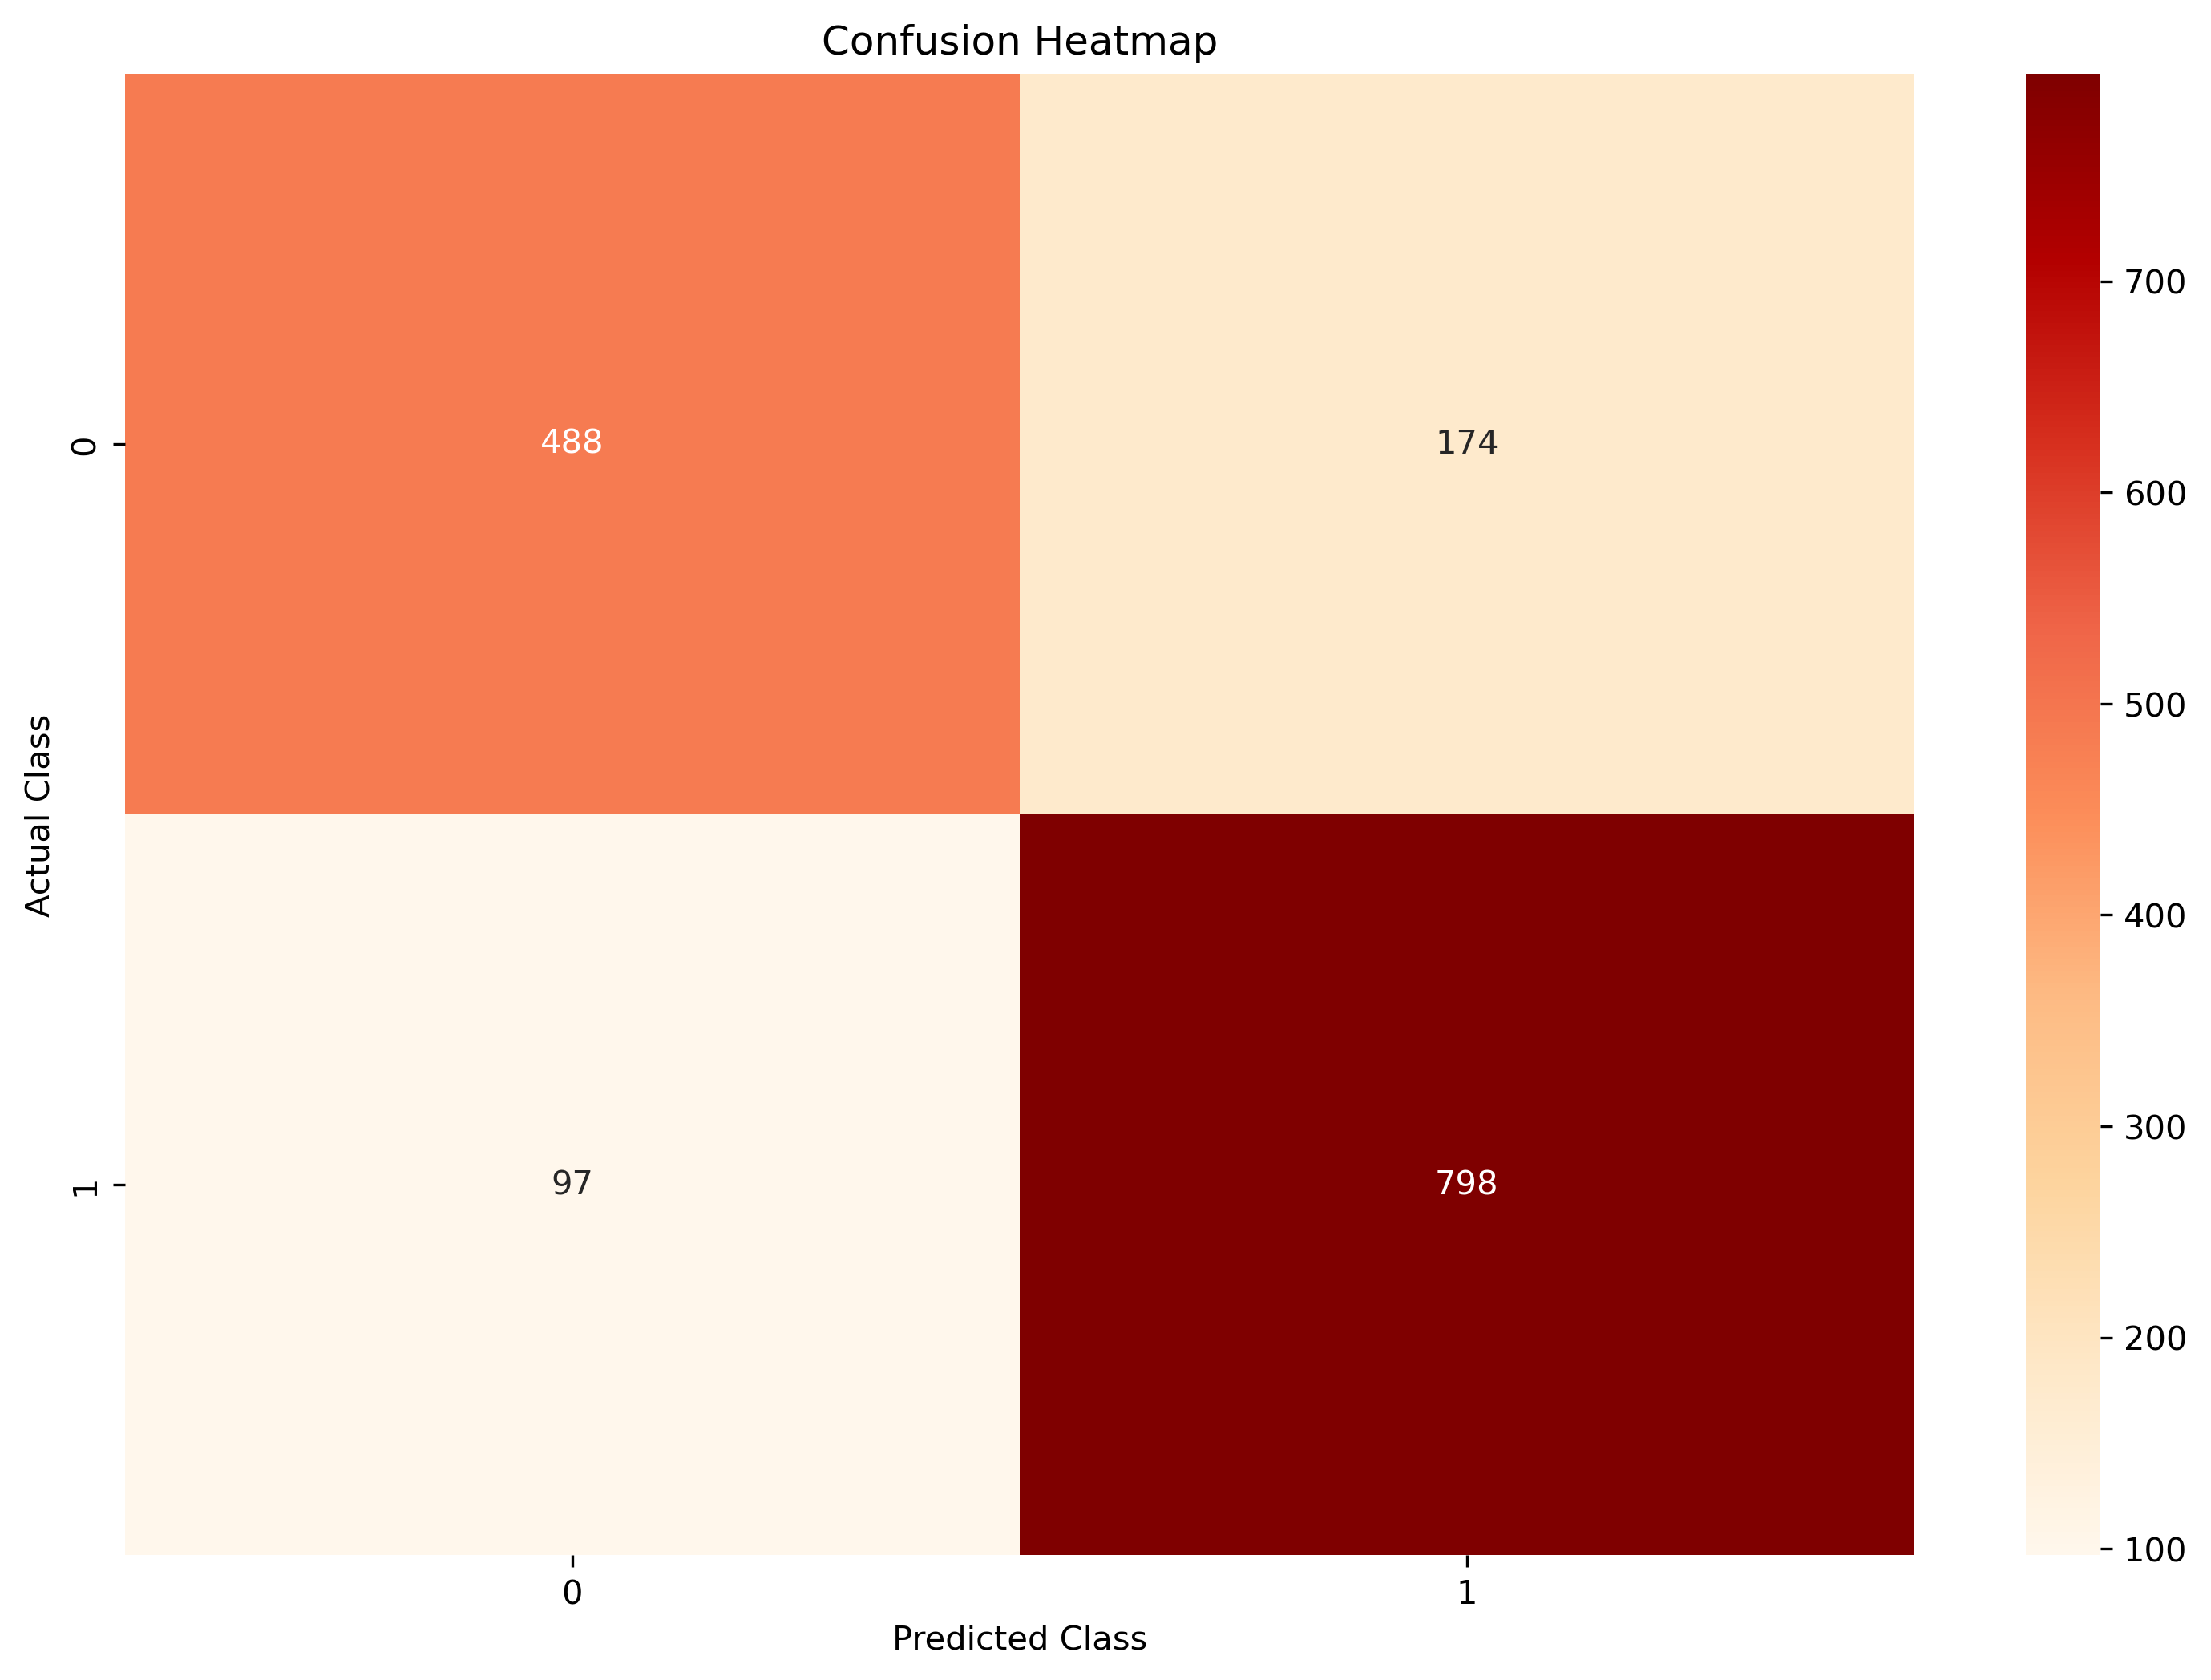

              precision    recall  f1-score   support

           0       0.83      0.74      0.78       662
           1       0.82      0.89      0.85       895

    accuracy                           0.83      1557
   macro avg       0.83      0.81      0.82      1557
weighted avg       0.83      0.83      0.82      1557



In [15]:
# Make classifications based on the test features, and assign the classifications to a variable
y_pred = XGB_3.predict(X_test)

predictions = y_test.unique()
predictions.sort()

# Build the confusion matrix as a dataframe
confusion_df = pd.DataFrame(confusion_matrix(y_test, y_pred))
confusion_df.index = [i for i in predictions]
confusion_df.columns = [i for i in predictions]

# Heatmap of the above
plt.figure(figsize=(12, 8), dpi=300)
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='OrRd') # Passing in fmt='d' prevents the counts from being displayed in scientific notation
plt.title('Confusion Heatmap')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

print(classification_report(y_test, y_pred))

In [16]:
# Model Evaluation metrics 
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))
print('ROC AUC Score : ' + str(roc_auc_score(y_test,y_pred)))

Accuracy Score : 0.8259473346178549
Precision Score : 0.8209876543209876
Recall Score : 0.8916201117318435
F1 Score : 0.8548473486877344
ROC AUC Score : 0.8143901162888826


In [17]:
# Append the scores of the baseline logistic regression model to the dataframe
appendScores("Depth3_XGB", y_test, y_pred)

,ModelName,Test Accuracy,Test Precision,Test Recall,Test F1,Test ROC AUC
0,Baseline_XGB,0.842646,0.845745,0.888268,0.866485,0.834617
1,Depth3_XGB,0.825947,0.820988,0.891620,0.854847,0.814390


### 5-folds Cross Validation

In [18]:
from sklearn.model_selection import cross_val_score

# Generate depths
depths = list(range(1, 11))

# Initialise list
cross_validation_scores = []

# Iteratively create models
for depth in depths:
    print(f'Fitting model: {depth}', end='\r')
    XGB = XGBClassifier(max_depth=depth, random_state=1)
    cv_score = np.mean(cross_val_score(XGB, X_rem, y_rem, cv = 5))
    cross_validation_scores.append(cv_score)

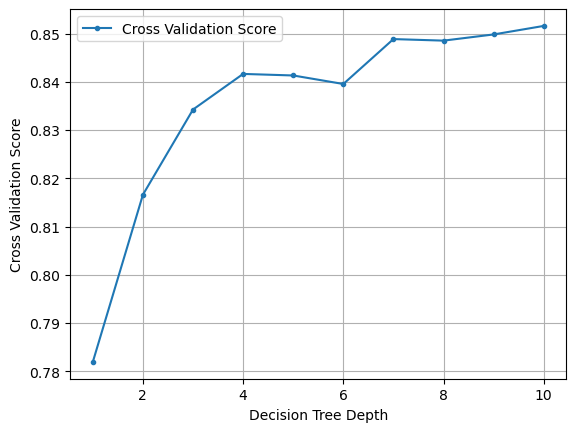

In [19]:
plt.figure()
plt.plot(depths, cross_validation_scores,label="Cross Validation Score",marker='.')
plt.legend()
plt.xlabel('Decision Tree Depth')
plt.ylabel('Cross Validation Score')
plt.grid()
plt.show()

In [20]:
optimum_depth = depths[np.argmax(cross_validation_scores)]
print(f'The optimum depth for the decision tree model is {optimum_depth}')

The optimum depth for the decision tree model is 10


In [21]:
# Instantiate the model
XGB_10 = XGBClassifier(max_depth=optimum_depth,random_state=1)

# Fit the model
XGB_10.fit(X_train, y_train)

# Scoring the model
XGB_10.score(X_train, y_train)
XGB_10.score(X_test, y_test)

print(f'XGB with a depth of {optimum_depth} achieved a Train result: {XGB_10.score(X_train, y_train):.4f} accuracy.')
print(f'XGB with a depth of {optimum_depth} achieved a Test result: {XGB_10.score(X_test, y_test):.4f} accuracy.')

XGB with a depth of 10 achieved a Train result: 0.9998 accuracy.
XGB with a depth of 10 achieved a Test result: 0.8369 accuracy.


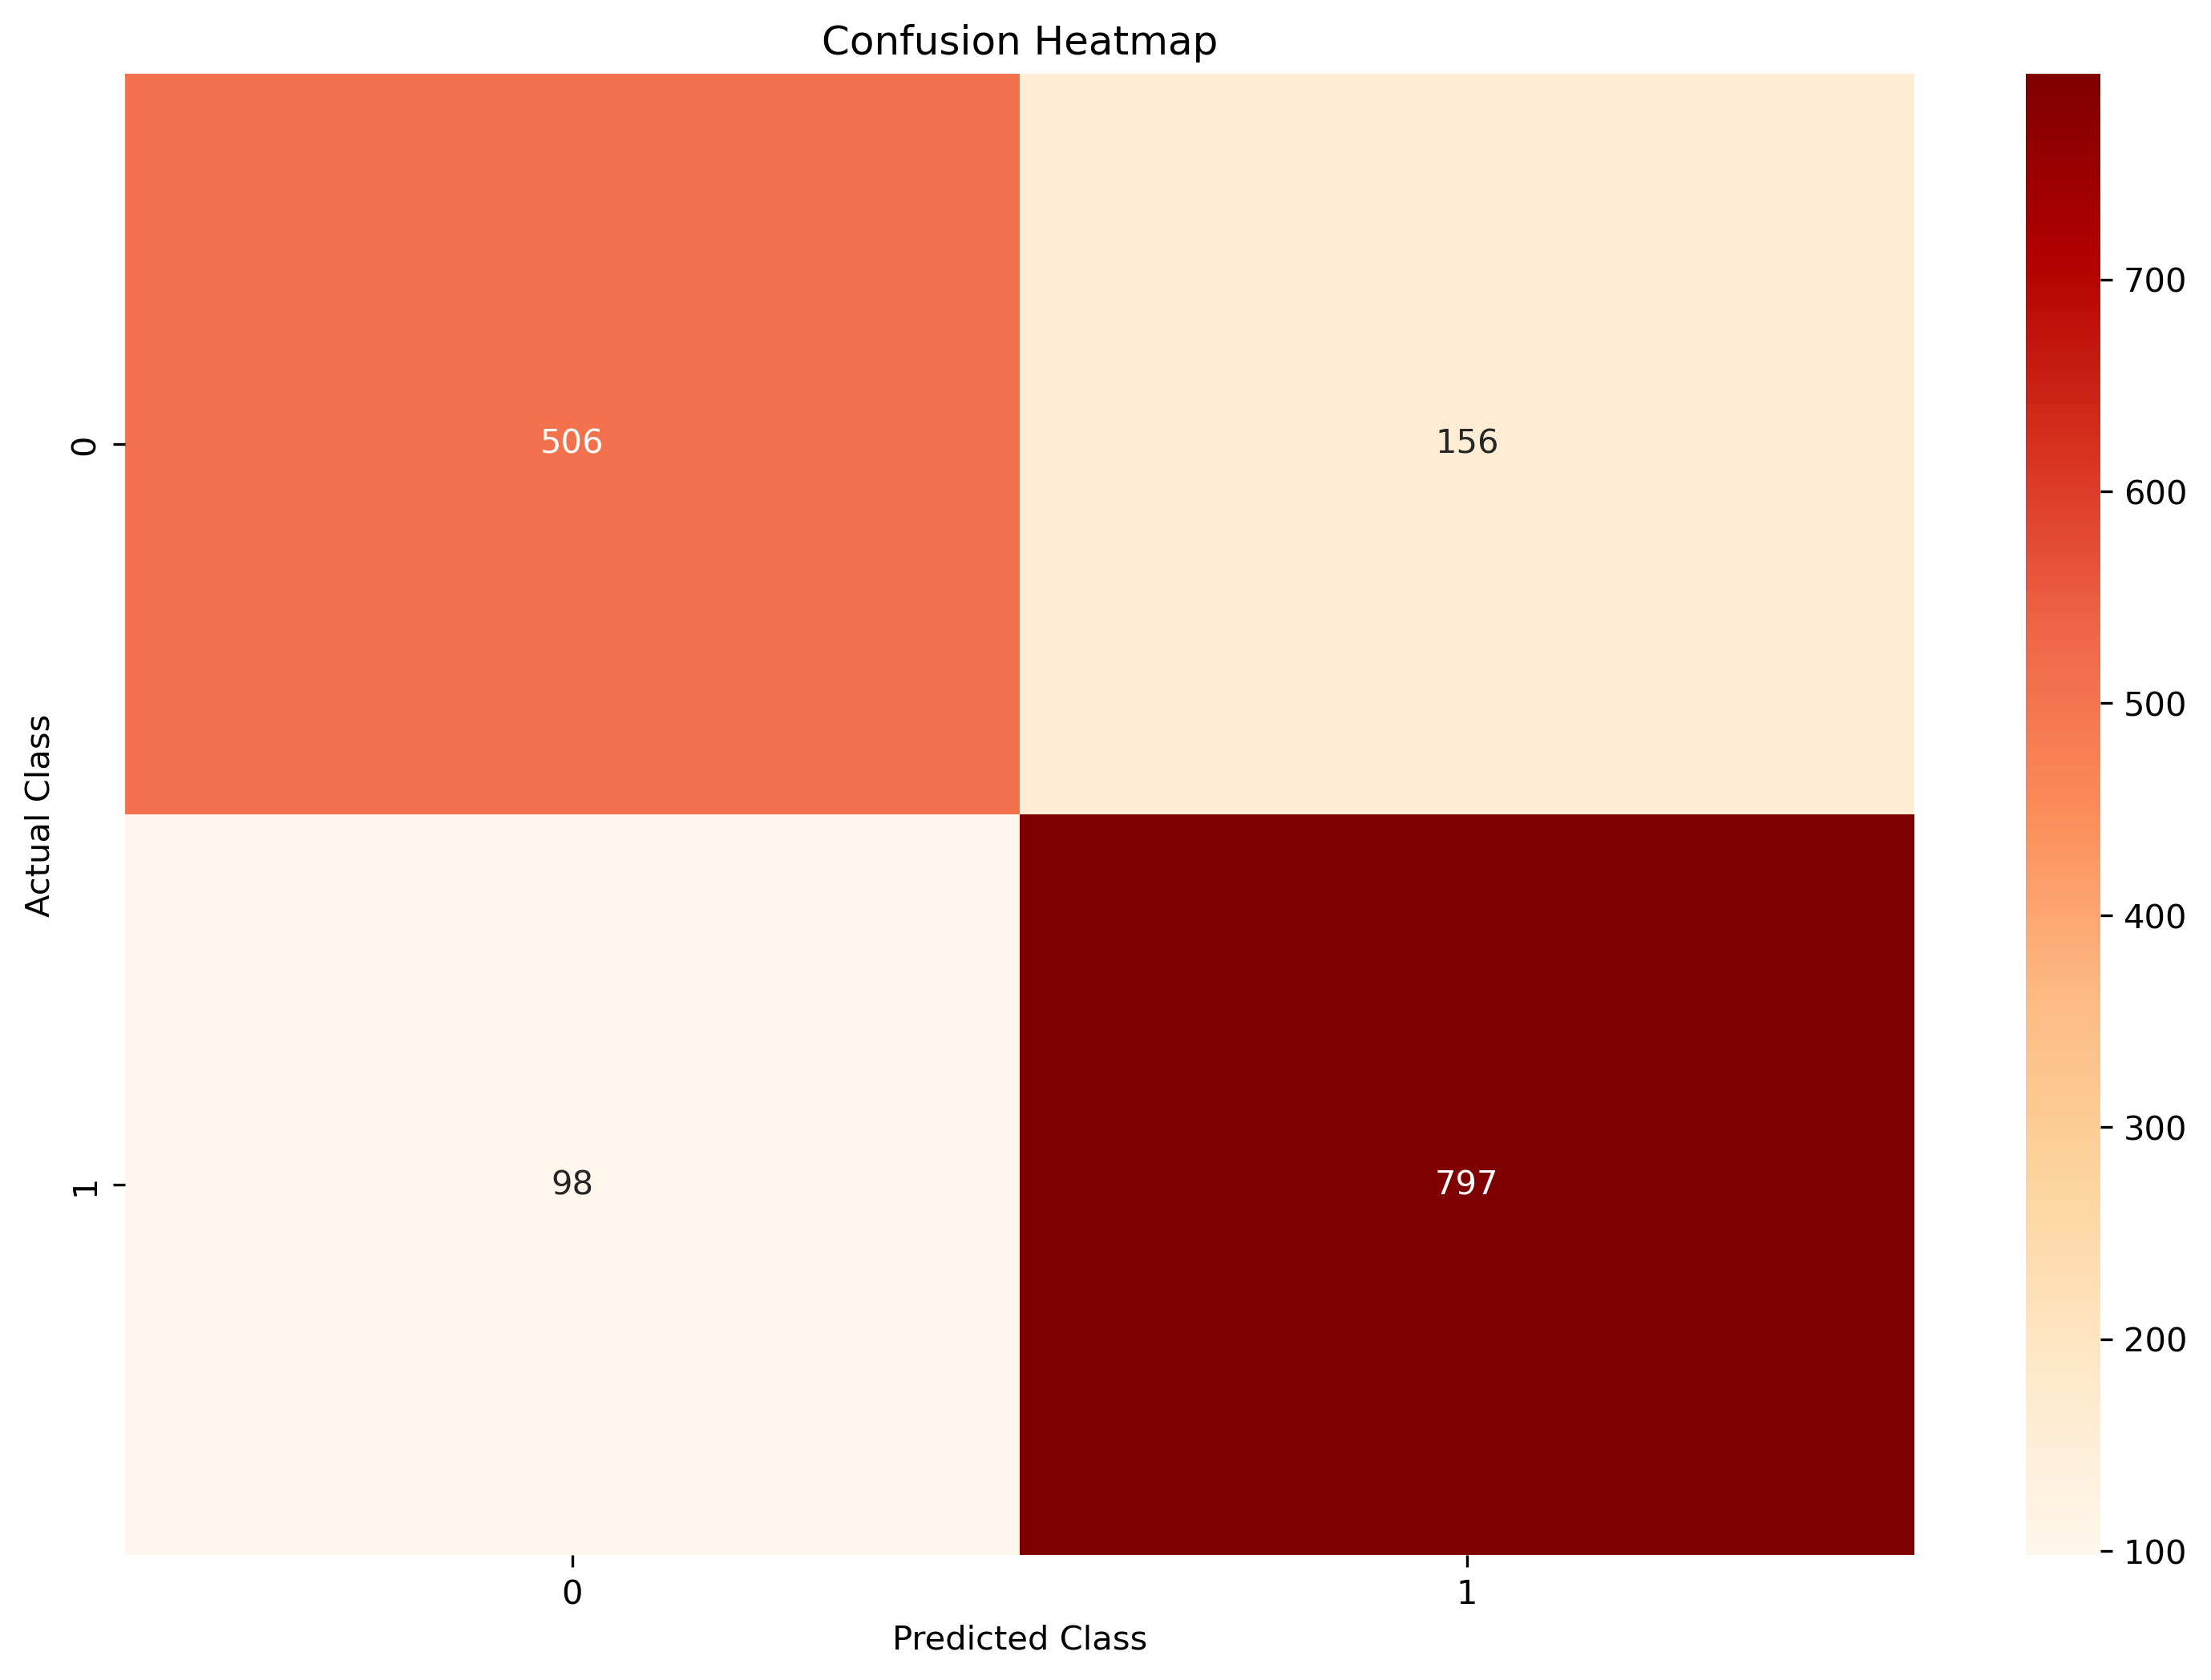

              precision    recall  f1-score   support

           0       0.84      0.76      0.80       662
           1       0.84      0.89      0.86       895

    accuracy                           0.84      1557
   macro avg       0.84      0.83      0.83      1557
weighted avg       0.84      0.84      0.84      1557



In [24]:
# Make classifications based on the test features, and assign the classifications to a variable
y_pred = XGB_10.predict(X_test)

predictions = y_test.unique()
predictions.sort()

# Build the confusion matrix as a dataframe
confusion_df = pd.DataFrame(confusion_matrix(y_test, y_pred))
confusion_df.index = [i for i in predictions]
confusion_df.columns = [i for i in predictions]

# Heatmap of the above
plt.figure(figsize=(12, 8), dpi=300)
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='OrRd') # Passing in fmt='d' prevents the counts from being displayed in scientific notation
plt.title('Confusion Heatmap')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

print(classification_report(y_test, y_pred))

In [25]:
# Model Evaluation metrics 
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))
print('ROC AUC Score : ' + str(roc_auc_score(y_test,y_pred)))

Accuracy Score : 0.8368657675016057
Precision Score : 0.8363064008394544
Recall Score : 0.8905027932960894
F1 Score : 0.8625541125541125
ROC AUC Score : 0.8274266232341474


In [26]:
# Append the scores of the baseline logistic regression model to the dataframe
appendScores("Depth10_XGB", y_test, y_pred)

,ModelName,Test Accuracy,Test Precision,Test Recall,Test F1,Test ROC AUC
0,Baseline_XGB,0.842646,0.845745,0.888268,0.866485,0.834617
1,Depth3_XGB,0.825947,0.820988,0.891620,0.854847,0.814390
2,Depth10_XGB,0.836866,0.836306,0.890503,0.862554,0.827427


At depth of 10, the recall score is slightly lower than depth of 3 while the model is overfitting significantly. This suggests the XGBoost Classifier at depth of 3 is a better classifier.

---

## 5-folds Cross Validaton with Grid Search <a id="gridsearchcv"></a>

The grid search that we are implementing at this stage is going to test multiple different hyperparameters for a decision tree model. The hyperparameters that we will be analysing are:

- Max depth: this will determine the depth of the tree. We will not be using an excessive amount of depths in the grid search as we have already found values in the range of 2 to 20.
- Critertion: this is the function used to measure the quality of a split.
- Min samples leaf: this determines the minimum number of leaves that a node must have. By setting a maximum value, we are preventing a node from only having one lead - and consequently over-fitting.

In [27]:
from sklearn.metrics import balanced_accuracy_score

# Set up a directory to cache the pipeline results
cachedir = mkdtemp()

estimators = [('scaler', StandardScaler()),
              ('model', XGBClassifier())

]

# Set up a pipeline
# The steps here act as placeholders and will be changed when we pass the pipeline into the grid search later
pipe = Pipeline(estimators, memory=cachedir)

depths = list(range(2, 21))

# Parameter grid
param_grid = [
    {'scaler': [StandardScaler(),MinMaxScaler(), None],
     'model__max_depth': depths,
     'model__n_estimators': np.arange(1, 200, 10),
     'model__random_state': [1]

    }
]

# Instantiate the log reg grid search
grid = GridSearchCV(pipe, param_grid=param_grid, scoring=make_scorer(balanced_accuracy_score), cv=5, n_jobs=-1, verbose=1)

# Fit the log reg grid search
fittedGrid = grid.fit(X_rem, y_rem)

Fitting 5 folds for each of 1140 candidates, totalling 5700 fits


In [28]:
fittedGrid.best_params_

{'model__max_depth': 10,
 'model__n_estimators': 91,
 'model__random_state': 1,
 'scaler': None}

In [29]:
# Print the accuracies
print(f"The best XGBoost's accuracy on the remainder set: {fittedGrid.score(X_rem, y_rem)}")
print(f"The best XGBoost's accuracy on the test set: {fittedGrid.score(X_test, y_test)}")

The best XGBoost's accuracy on the remainder set: 0.9985385439062542
The best XGBoost's accuracy on the test set: 0.826702560380766


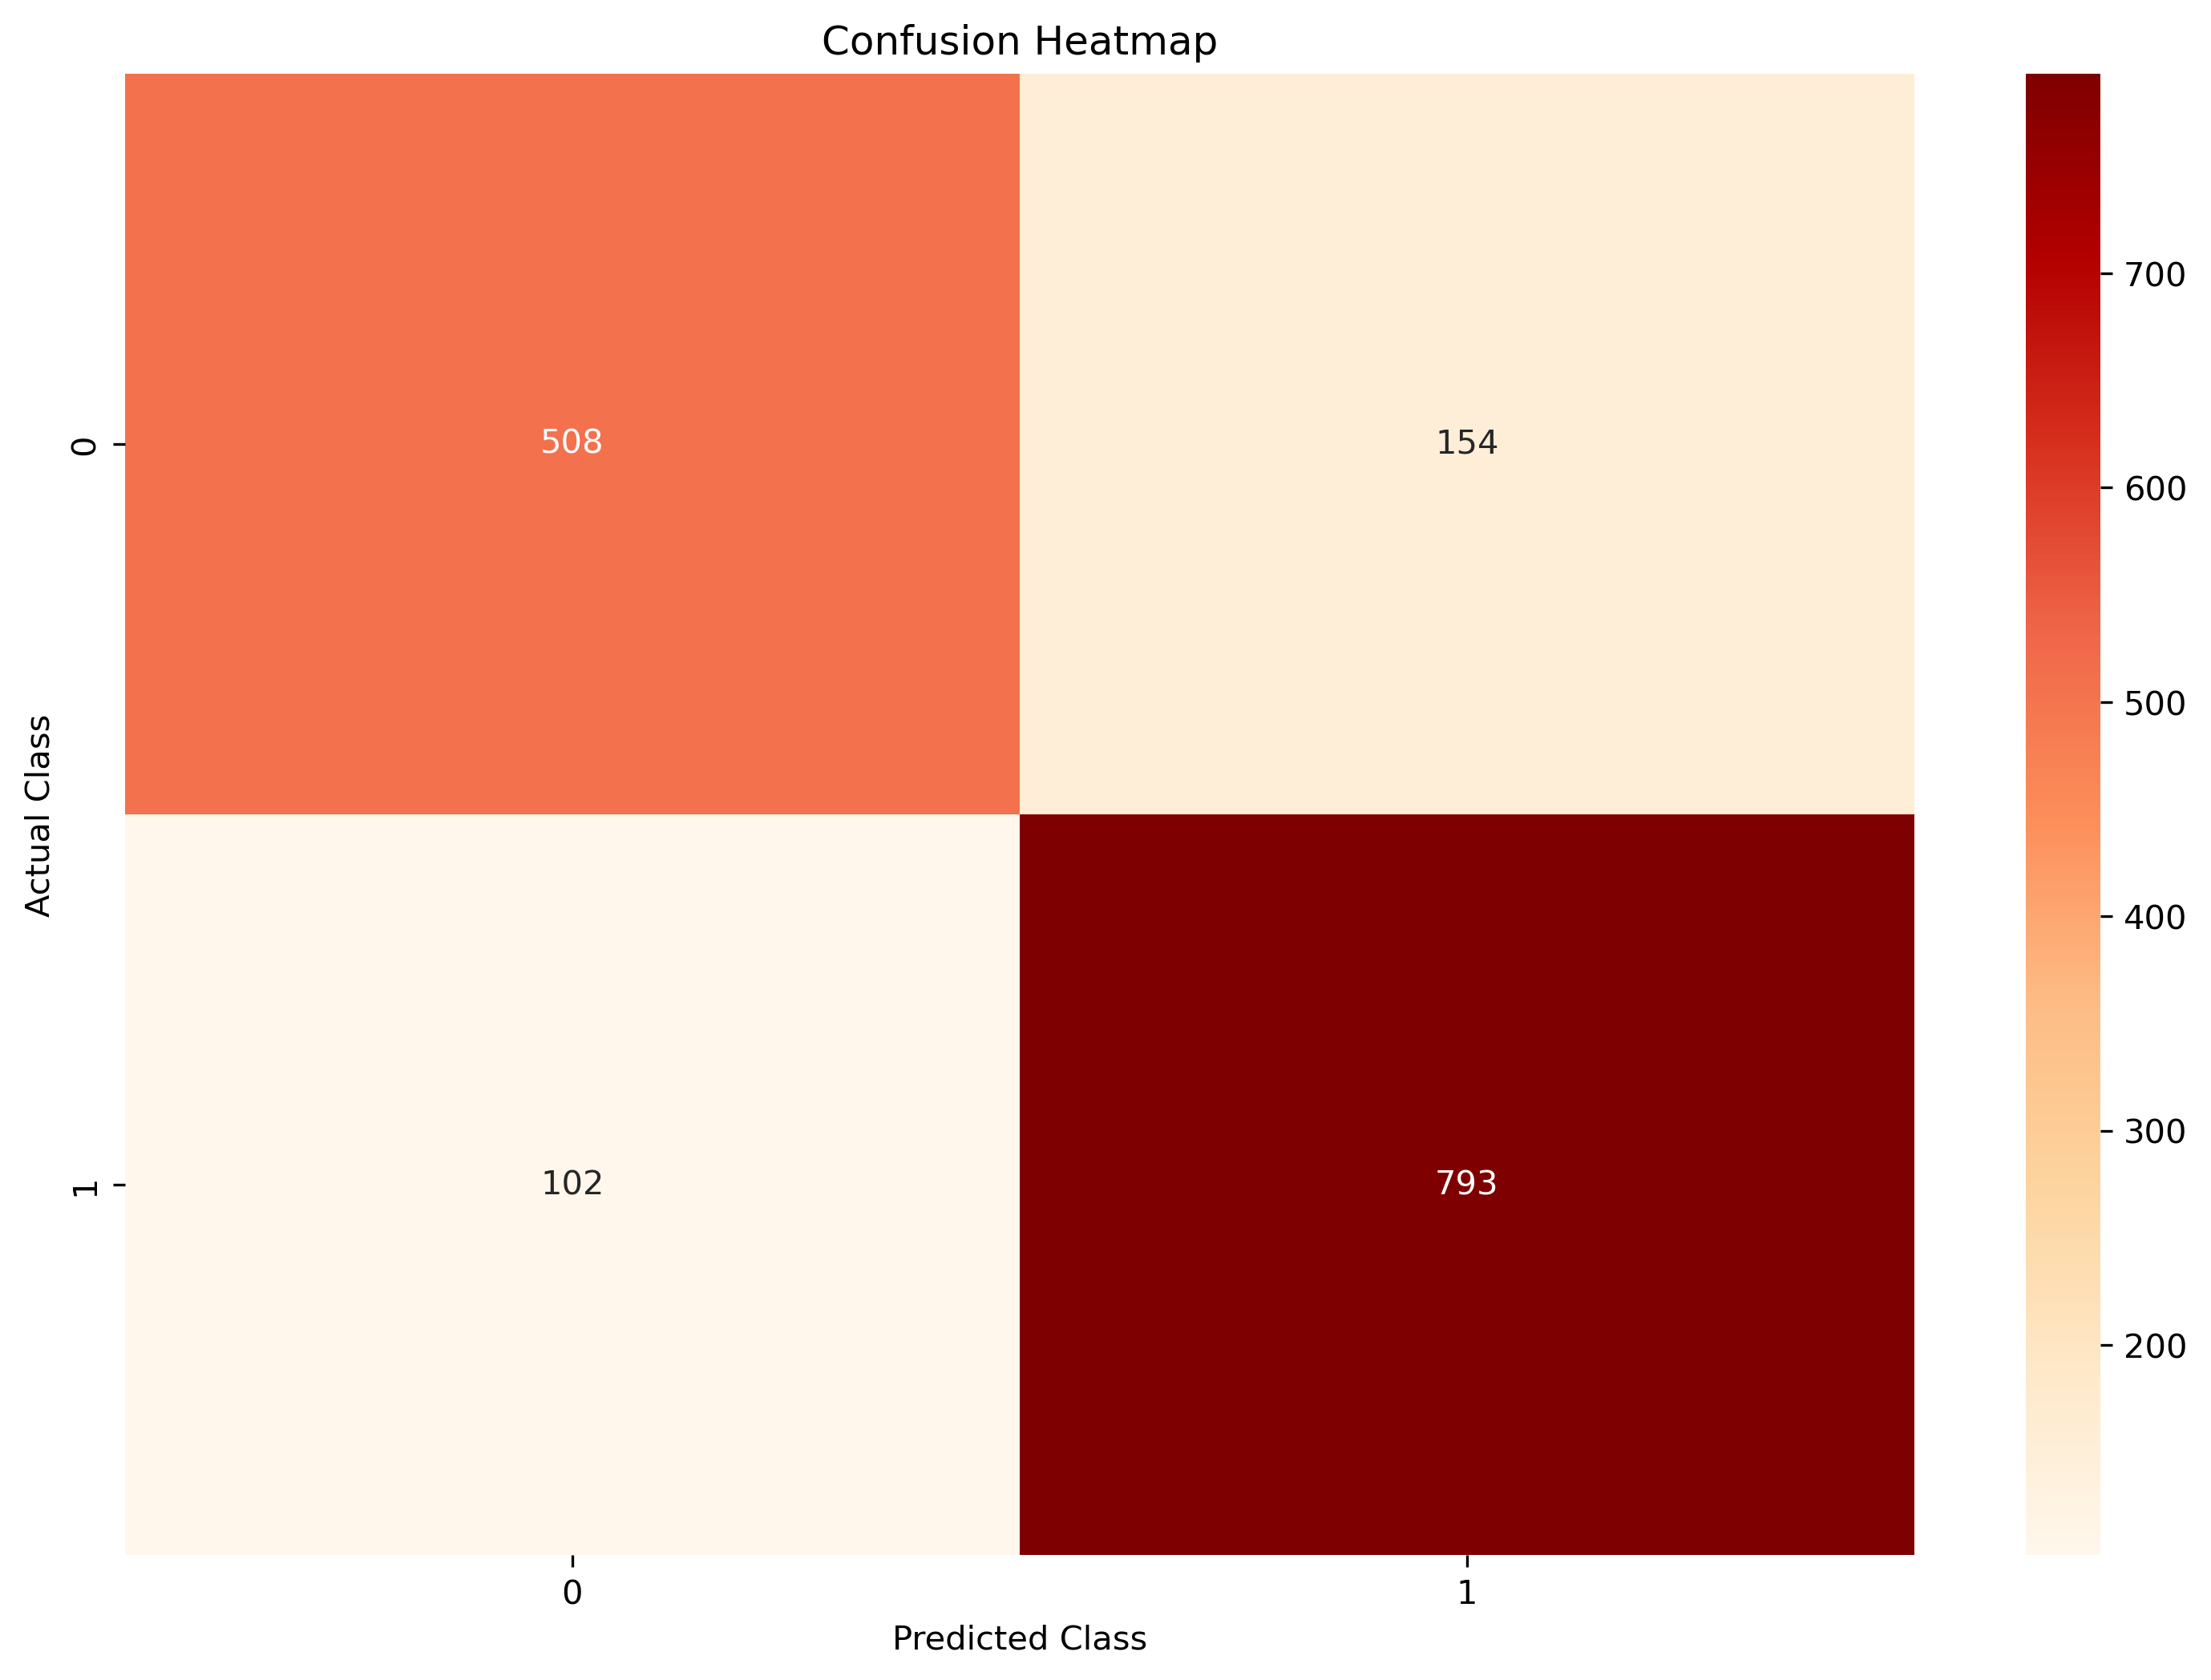

              precision    recall  f1-score   support

           0       0.83      0.77      0.80       662
           1       0.84      0.89      0.86       895

    accuracy                           0.84      1557
   macro avg       0.84      0.83      0.83      1557
weighted avg       0.84      0.84      0.83      1557



In [30]:
# Make classifications based on the test features, and assign the classifications to a variable
y_pred = fittedGrid.best_estimator_.predict(X_test)

predictions = y_test.unique()
predictions.sort()

# Build the confusion matrix as a dataframe
confusion_df = pd.DataFrame(confusion_matrix(y_test, y_pred))
confusion_df.index = [i for i in predictions]
confusion_df.columns = [i for i in predictions]

# Heatmap of the above
plt.figure(figsize=(12, 8), dpi=300)
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='OrRd') # Passing in fmt='d' prevents the counts from being displayed in scientific notation
plt.title('Confusion Heatmap')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

print(classification_report(y_test, y_pred))

In [31]:
# Model Evaluation metrics 
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))
print('ROC AUC Score : ' + str(roc_auc_score(y_test,y_pred)))

Accuracy Score : 0.8355812459858702
Precision Score : 0.8373812038014784
Recall Score : 0.8860335195530726
F1 Score : 0.8610206297502716
ROC AUC Score : 0.826702560380766


In [32]:
# Append the scores of the baseline logistic regression model to the dataframe
appendScores("Depth19_GridSearch_XGB", y_test, y_pred)

,ModelName,Test Accuracy,Test Precision,Test Recall,Test F1,Test ROC AUC
0,Baseline_XGB,0.842646,0.845745,0.888268,0.866485,0.834617
1,Depth3_XGB,0.825947,0.820988,0.891620,0.854847,0.814390
2,Depth10_XGB,0.836866,0.836306,0.890503,0.862554,0.827427
3,Depth19_GridSearch_XGB,0.835581,0.837381,0.886034,0.861021,0.826703


Using GridSearch didn't help us to get a better model compared to model we got previously. I will instead take the XGBoost at depth of 3 as the best model here as it has better recall scores and less overfitted.

In [33]:
best_model = XGB_3

## Top Features <a id="top-features"></a>

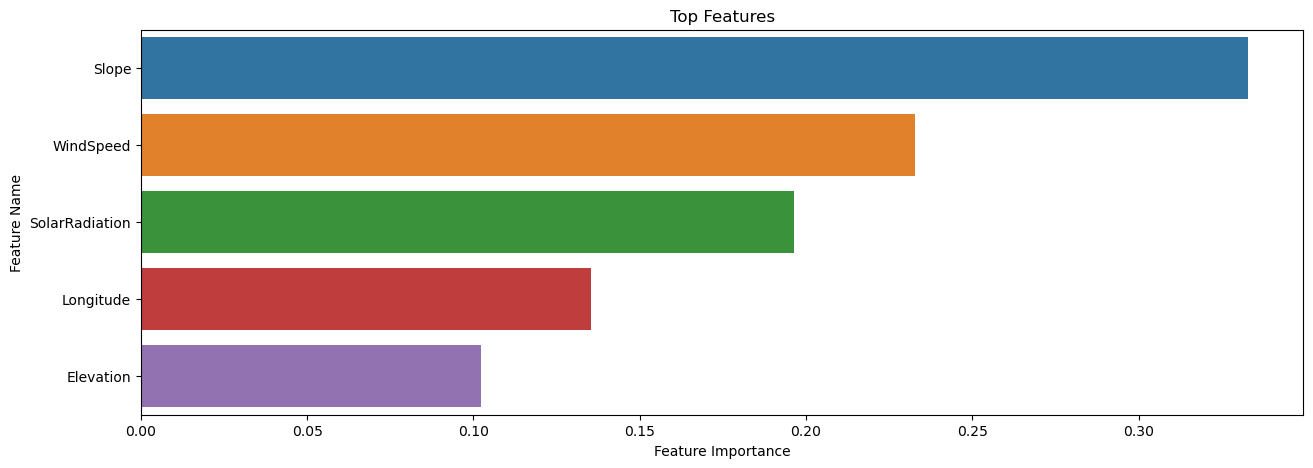

In [34]:
importances = best_model.feature_importances_
importances_df = pd.DataFrame({'Variable': X.columns,
                                'Importance': importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(15, 5))
plt.title('Top Features')
sns.barplot(x='Importance', y='Variable', data=importances_df.head(10))
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.show()

---

### Saving the model

In [36]:
import pickle
pickle.dump(best_model, open('./models/xgb_model.pkl', 'wb'))

### Loading the model

In [ ]:
import pickle
best_model = pickle.load(open('models/rf_model.pkl', 'rb'))